In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
os.chdir('..')
from src.regressions import *
from src.helpers import *
from src.statistical_analysis import *
from src.evaluation_metrics import *
from src.feature_engineering import *
os.chdir('notebooks')

## Loading and visualizing the dataset 

Load the dataset in a pandas dataframe.

In [3]:
PATH = os.path.join("..", "data", "Colombia.csv")

dataset = pd.read_csv(PATH)

Visualize the dataset.

In [4]:
dataset

,YEAR,Colombia/CGPD RELATIVE TO THE UNITED STATES (unit US=100),Colombia/CONSUMPTION SHARE OF CGPD (unit %),Colombia/CONSUMPTION SHARE OF RGDPL (unit %),Colombia/CURRENT SAVINGS (unit %),Colombia/EXCHANGE RATE (unit US=1),Colombia/GOVERNMENT SHARE OF CGDP (unit %),Colombia/GOVERNMENT SHARE OF RGDPL (unit %),Colombia/INVESTMENT SHARE OF CGDP (unit %),Colombia/INVESTMENT SHARE OF RGDPL (unit %),Colombia/OPENNESS IN CONSTANT PRICES (unit %),Colombia/OPENNESS IN CURRENT PRICES (unit %),Colombia/POPULATION (unit 000S),Colombia/PRICE LEVEL OF CONSUMPTION (unit PPP/XRATE),Colombia/PRICE LEVEL OF GOVERNMENT (unit PPP/XRATE),Colombia/PRICE LEVEL OF GROSS DOMESTIC PRODUCT (unit US=100),Colombia/PRICE LEVEL OF INVESTMENT (unit PPP/XRATE),Colombia/RATIO OF GNP TO GDP (CURRENT PRICES) (unit %),Colombia/REAL GROSS DOMESTIC PRODUCT PER CAPITA (CURRENT PRICES) (unit $ CURRENT)
0,1950,20.743432,76.913461,76.054215,15.173068,1.949824,7.913471,11.745797,14.779865,12.662297,24.502413,20.547583,12454.85341,93.799860,87.221589,95.646129,109.764680,NaN,400.877396
1,1951,19.561267,76.057855,74.076242,14.948633,2.400553,8.993511,12.767291,14.158628,11.736539,24.736634,26.084366,12776.96171,81.156692,68.514725,80.868631,87.168371,NaN,427.308742
2,1952,19.903686,76.105726,74.191959,14.836089,2.510486,9.058184,12.787814,14.311066,11.690103,23.452196,25.162930,13206.43942,76.556135,66.744127,76.649725,83.417180,NaN,450.519889
3,1953,20.410125,74.205448,73.098890,15.828397,2.510486,9.966155,14.296454,15.197825,12.604656,28.402434,29.517252,13635.91713,78.666419,68.515372,77.542772,77.976243,NaN,480.355227
4,1954,22.373138,73.638783,74.370978,16.788322,2.510486,9.572895,13.828367,16.884319,14.553693,26.612700,28.825568,13958.02542,84.805048,76.929188,83.823992,83.454386,NaN,515.908247
5,1955,20.909343,74.724139,74.435350,15.212711,2.510486,10.063150,13.890463,17.514677,14.786457,26.366215,26.143491,14387.50313,84.422037,77.398187,84.119909,86.692920,NaN,517.884423
6,1956,20.713327,73.650267,73.839031,16.755262,2.510486,9.594471,13.105041,17.363101,14.431419,24.873453,24.476167,14816.98085,89.911000,79.056686,89.613429,94.184632,NaN,529.727661
7,1957,20.309660,74.587806,74.852878,16.812574,3.797711,8.599620,11.554770,15.750422,12.968359,22.633917,28.240832,15246.45857,65.046758,59.163854,67.838411,85.794827,NaN,537.188616
8,1958,20.369658,75.168088,74.283029,15.827412,6.401141,9.004500,11.798852,13.428949,10.980755,21.226614,33.870354,15783.30571,42.670454,37.893569,45.006192,62.849631,NaN,539.217665
9,1959,19.831478,75.291283,73.623096,15.917831,6.401141,8.790886,11.229071,13.530778,10.875441,21.987187,30.866151,16212.78343,45.593926,41.506532,48.124471,66.505199,NaN,560.538590


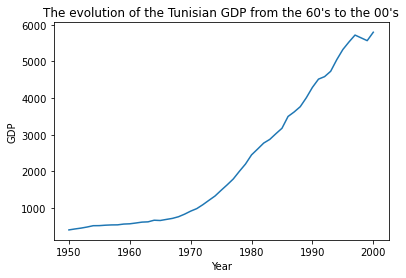

In [7]:
plt.plot(dataset["YEAR"], dataset["Colombia/REAL GROSS DOMESTIC PRODUCT PER CAPITA (CURRENT PRICES) (unit $ CURRENT)"])
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("The evolution of the Colombian GDP from the 50's to the 00's")
plt.show()

In [8]:
X, y = X_y_from_dataset(dataset)

print("We have", X.shape[0], "data points and", X.shape[1], "features")

We have 41 data points and 18 features


Verify whether there are highly correlated features.

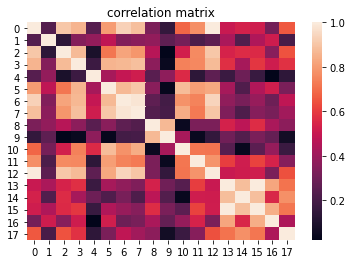

YEAR is highly correlated with:  Colombia/CONSUMPTION SHARE OF CGPD (unit %), Colombia/CONSUMPTION SHARE OF RGDPL (unit %), Colombia/EXCHANGE RATE (unit US=1), Colombia/GOVERNMENT SHARE OF CGDP (unit %), Colombia/GOVERNMENT SHARE OF RGDPL (unit %), Colombia/POPULATION (unit 000S) 

Colombia/CONSUMPTION SHARE OF CGPD (unit %) is highly correlated with:  YEAR, Colombia/CONSUMPTION SHARE OF RGDPL (unit %), Colombia/GOVERNMENT SHARE OF CGDP (unit %), Colombia/POPULATION (unit 000S) 

Colombia/CONSUMPTION SHARE OF RGDPL (unit %) is highly correlated with:  YEAR, Colombia/CONSUMPTION SHARE OF CGPD (unit %), Colombia/EXCHANGE RATE (unit US=1), Colombia/GOVERNMENT SHARE OF CGDP (unit %), Colombia/GOVERNMENT SHARE OF RGDPL (unit %), Colombia/POPULATION (unit 000S) 

Colombia/EXCHANGE RATE (unit US=1) is highly correlated with:  YEAR, Colombia/CONSUMPTION SHARE OF RGDPL (unit %), Colombia/GOVERNMENT SHARE OF CGDP (unit %), Colombia/GOVERNMENT SHARE OF RGDPL (unit %), Colombia/OPENNESS IN CONSTAN

In [10]:
correlation_matrix = np.abs(np.corrcoef(X, rowvar=False))

sns.heatmap(correlation_matrix)
plt.title("correlation matrix")
plt.show()

mask = correlation_matrix > 0.8
np.fill_diagonal(mask, False)
for i, m in enumerate(mask): 
    if (sum(m) != 0):
        print(dataset.columns[i], "is highly correlated with: ",
              ", ".join(dataset.columns[np.append(m, False)]), "\n")

<AxesSubplot:xlabel='YEAR', ylabel='Colombia/POPULATION (unit 000S)'>

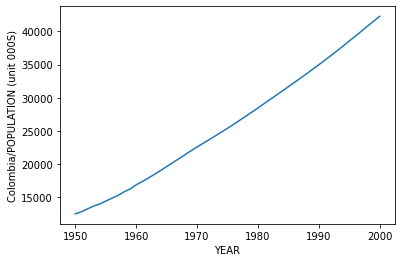

In [12]:
sns.lineplot(x="YEAR", y="Colombia/POPULATION (unit 000S)", data=dataset)

In [13]:
print("The condition number is", condition_number(X))

The condition number is 22346935.393850874


In [14]:
VIF_X = VIF(X)
print("The VIF is:", VIF_X, "\n The column with the highest VIF is", dataset.columns[np.argmax(VIF_X)])

The VIF is: [7.00539100e+04 7.02908234e+00 2.11533153e+06 1.05912123e+02
 9.15770541e+05 3.11026078e+02 2.84220356e+06 6.51175891e+02
 4.30206908e+02 3.45334859e+02 1.03573045e+02 5.11731286e+01
 7.77553920e+04 8.12257441e+03 3.16204401e+02 1.60875842e+04
 3.99639886e+02 1.86186906e+01] 
 The column with the highest VIF is Colombia/GOVERNMENT SHARE OF CGDP (unit %)


In [15]:
_, p_value, s = breusch_pagan_test(X, y)
print(s, "because the p-value is: ", p_value)

No significant heteroskedasticity. because the p-value is:  0.6655122885037975


## The models

Split the data into 80% training and 20% testing sets.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Least Squares

Train with the least squares estimator.

1

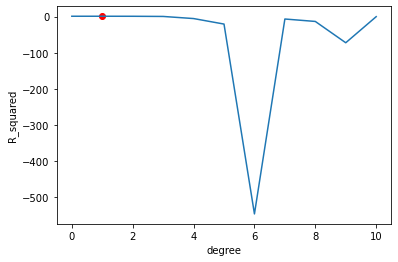

In [19]:
# Degree of zero means we leave the data set the way it is degree of 1 means we simply add a bias degree > 1
# We compute the polynomial expansion associated with that degree.
d = degree_cross_val(X_train, y_train, 10)
d

In [20]:
# We split the dataset as instructed: the first 80% as train and the next 20% as test.
X_ls = build_poly(X, d)
X_train_ls, X_test_ls, _, _ = train_test_split(X_ls, y)

In [21]:
LS_w = least_squares(X_train_ls, y_train)

LS_prediction_data = predict(X_ls, LS_w)
LS_prediction_test = predict(X_test_ls, LS_w)

In [22]:
print("Testing R^2: ", R_squared(y_test, LS_prediction_test),
      "\nFull data R^2:", R_squared(y, LS_prediction_data))

Testing R^2:  -0.9335047035670634 
Full data R^2: 0.9770023706801624


In [23]:
print("Full data adjusted R^2:", adjusted_R_squared(y, LS_prediction_data, X.shape[1]))

Full data adjusted R^2: 0.9581861285093861


Compute the CI for the coefficients.

In [25]:
X_for_var, w_for_var = (X_ls[:, 1:], LS_w[1:]) if d > 0 else (X, LS_w)
var = variance_least_squares_weights(X_for_var, y, LS_prediction_data)
lower_CI, upper_CI = confidence_interval(X_for_var.shape[0], X_for_var.shape[1], w_for_var, var)

Plot the coefficients with their CI intervals.

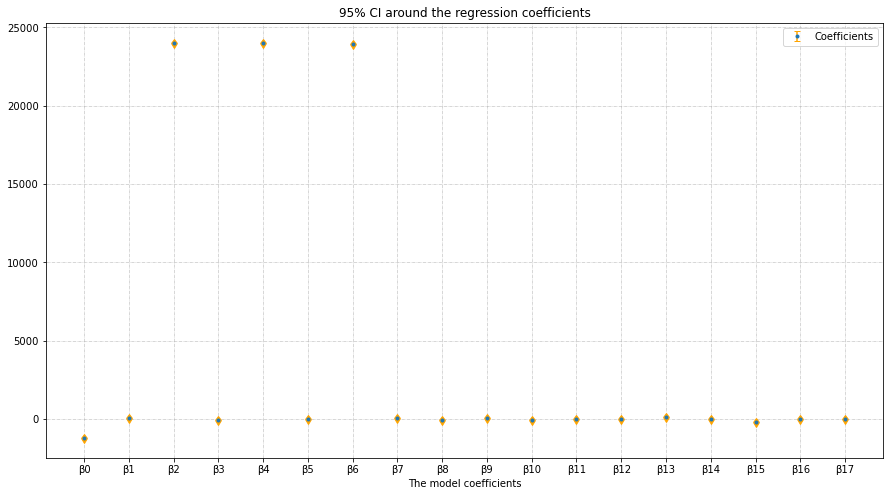

In [27]:
plt.figure(figsize=(15,8))
plt.errorbar(np.arange(X_for_var.shape[1]), w_for_var,
             yerr=np.vstack([np.squeeze(w_for_var-lower_CI), np.squeeze(upper_CI-w_for_var)]),
             fmt=".", ecolor='orange', lolims=True, uplims=True, label="Coefficients")
plt.xticks(np.arange(X.shape[1]), ["β"+str(i) for i in np.arange(X_for_var.shape[1])])
plt.title("95% CI around the regression coefficients")
plt.xlabel("The model coefficients")
plt.legend()
plt.grid(which='both', linestyle='-.', linewidth=0.5)
plt.show()

Compute the CI for the predictions.

In [28]:
var_ = variance_least_squares_line(X_for_var, y, LS_prediction_data)
lower_CI_line, upper_CI_line = confidence_interval(X_for_var.shape[0], X_for_var.shape[1], LS_prediction_data,
                                                   var_)

Plot the CI for the predictions.

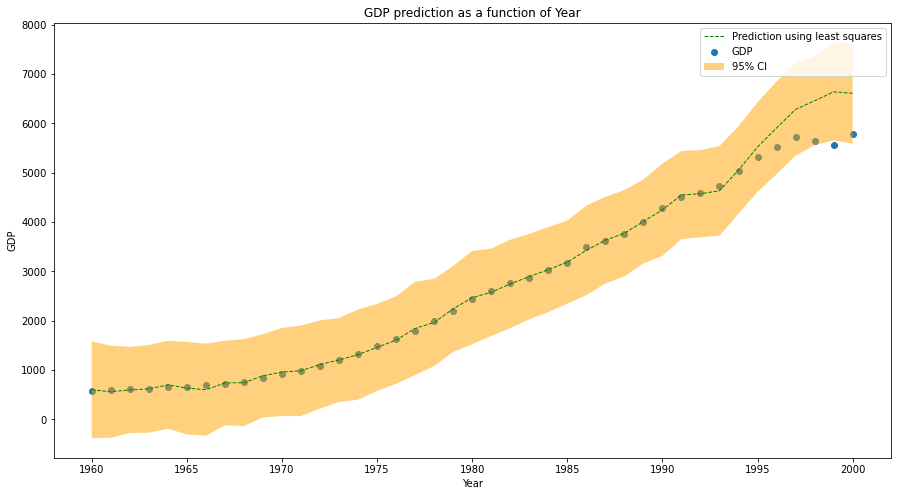

In [29]:
plt.figure(figsize=(15,8))
plt.scatter(X[:, 0], y, label="GDP")
plt.plot(X[:, 0], LS_prediction_data, color="g", lw=1, ls='--', label="Prediction using least squares")
plt.gca().fill_between(X[:, 0], np.squeeze(lower_CI_line), np.squeeze(upper_CI_line),
                       label="95% CI",
                       #color="#b9cfe7",
                       color="orange",
                       alpha=0.5,
                       edgecolor=None)
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("GDP prediction as a function of Year")
plt.legend()
plt.show()

### Ridge Regression

Train the ridge regression model.

In [31]:
lambda_r, d_r = cross_val_ridge(X_train, y_train, plot=False)
X_rr = build_poly(X, d_r)
X_train_rr, X_test_rr, _, _ = train_test_split(X_rr, y)
print("The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively:",
      lambda_r, d_r)

The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively: 0.65 2


In [32]:
Ridge_w = ridge_regression(X_train_rr, y_train, lambda_r)
Ridge_prediction_data = predict(X_rr, Ridge_w)
Ridge_prediction_test = predict(X_test_rr, Ridge_w)

In [33]:
print("Testing R^2: ", R_squared(y_test, Ridge_prediction_test),
      "\nFull data R^2:", R_squared(y, Ridge_prediction_data))

Testing R^2:  -25.748512429870956 
Full data R^2: 0.6855506075084364


In [34]:
print("Full data adjusted R^2:", adjusted_R_squared(y, Ridge_prediction_data, X_rr.shape[1]))

Full data adjusted R^2: -3.1926585665541802


In [35]:
X_for_var_rr, w_for_var_rr = (X_rr[:, 1:], Ridge_w[1:]) if d_r > 0 else (X, Ridge_w)
var = variance_least_squares_weights(X_for_var_rr, y, Ridge_prediction_data)
lower_CI_r, upper_CI_r = confidence_interval(X_for_var_rr.shape[0], X_for_var_rr.shape[1], w_for_var_rr, var)

Plot the coefficients with their CI intervals.

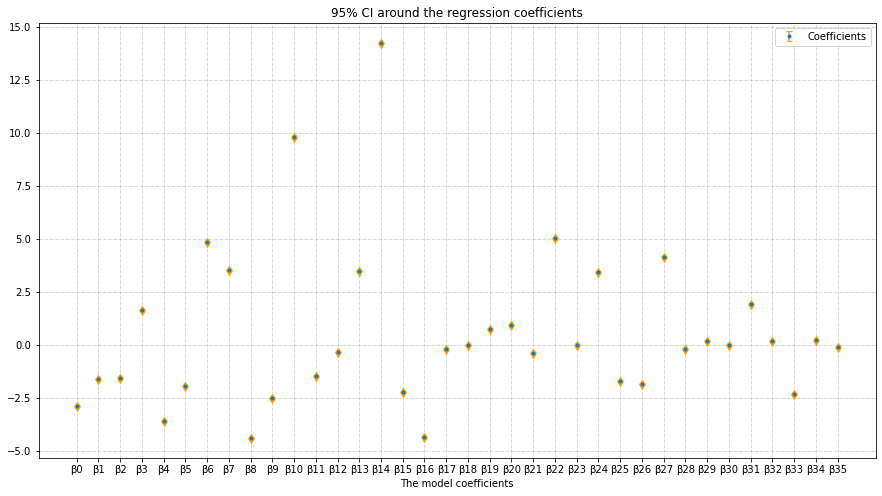

In [36]:
plt.figure(figsize=(15,8))

plt.errorbar(np.arange(X_for_var_rr.shape[1]), w_for_var_rr,
             yerr=np.vstack([np.squeeze(w_for_var_rr-lower_CI_r), np.squeeze(upper_CI_r-w_for_var_rr)]),
             fmt=".", ecolor='orange', lolims=True, uplims=True, label="Coefficients")

plt.xticks(np.arange(X_for_var_rr.shape[1]), ["β"+str(i) for i in np.arange(X_for_var_rr.shape[1])])

plt.title("95% CI around the regression coefficients")
plt.xlabel("The model coefficients")
plt.legend()
plt.grid(which='both', linestyle='-.', linewidth=0.5)
plt.show()

Compute the CI for the predictions.

In [37]:
var_ = variance_least_squares_line(X_for_var_rr, y, Ridge_prediction_data)
lower_CI_line_r, upper_CI_line_r = confidence_interval(X_for_var_rr.shape[0], X_for_var_rr.shape[1], Ridge_prediction_data, var_)

Plot the CI for the predictions.

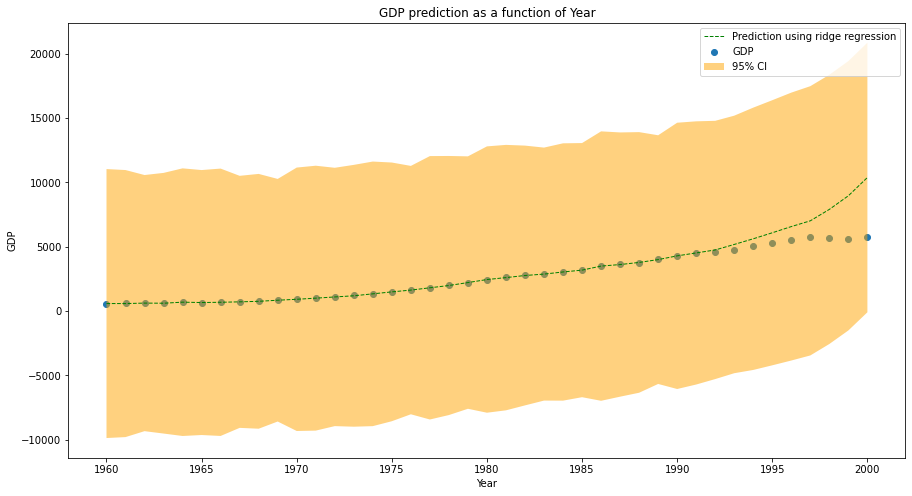

In [38]:
plt.figure(figsize=(15,8))
plt.scatter(X[:, 0], y, label="GDP")
plt.plot(X[:, 0], Ridge_prediction_data, color="g", lw=1, ls='--', label="Prediction using ridge regression")
plt.gca().fill_between(X[:, 0], np.squeeze(lower_CI_line_r), np.squeeze(upper_CI_line_r),
                       label="95% CI",
                       #color="#b9cfe7",
                       color="orange",
                       alpha=0.5,
                       edgecolor=None)
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("GDP prediction as a function of Year")
plt.legend()
plt.show()

### Subset selection

Find the optimal combination of features in terms of $r^2$.

In [39]:
scores, subsets = best_subset_ls(X_train, y_train)

In [40]:
i = np.argmax(scores)
sub = subsets[i]
variables = "\n\t- ".join(dataset.columns[list(sub)])
print("Best performance on the test: ", scores[i], "the subset is: ", sub)
print("This corresponds to the following variables:\n\t- " + variables)

Best performance on the test:  0.999283225788453 the subset is:  (2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17)
This corresponds to the following variables:
	- Colombia/CONSUMPTION SHARE OF CGPD (unit %)
	- Colombia/CONSUMPTION SHARE OF RGDPL (unit %)
	- Colombia/CURRENT SAVINGS (unit %)
	- Colombia/OPENNESS IN CONSTANT PRICES (unit %)
	- Colombia/OPENNESS IN CURRENT PRICES (unit %)
	- Colombia/POPULATION (unit 000S)
	- Colombia/PRICE LEVEL OF CONSUMPTION (unit PPP/XRATE)
	- Colombia/PRICE LEVEL OF GOVERNMENT (unit PPP/XRATE)
	- Colombia/PRICE LEVEL OF GROSS DOMESTIC PRODUCT (unit US=100)
	- Colombia/PRICE LEVEL OF INVESTMENT (unit PPP/XRATE)
	- Colombia/RATIO OF GNP TO GDP (CURRENT PRICES) (unit %)


In [41]:
X_ss = X[:, sub]
X_train_ss, X_test_ss, _, _ = train_test_split(X_ss, y)

Compute lest squares estimator using subset of features.

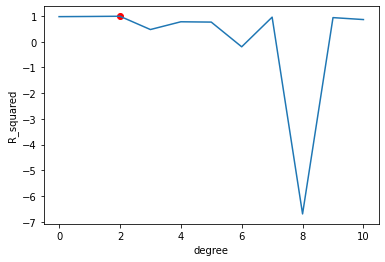

In [42]:
d_ss = degree_cross_val(X_train_ss, y_train, 10)
X_ls_ss = build_poly(X_ss, d_ss)
X_train_ls_ss, X_test_ls_ss, _, _ = train_test_split(X_ls_ss, y)

In [43]:
LS_w_ss = least_squares(X_train_ls_ss, y_train)

LS_ss_prediction_data = predict(X_ls_ss, LS_w_ss)
LS_ss_prediction_test = predict(X_test_ls_ss, LS_w_ss)

In [44]:
print("Testing R^2:  ", R_squared(y_test, LS_ss_prediction_test),
      "\nFull data R^2:", R_squared(y, LS_ss_prediction_data))

Testing R^2:   -1.3953811932433093 
Full data R^2: 0.9718146657931259


In [45]:
print("Full data adjusted R^2:", adjusted_R_squared(y, LS_ss_prediction_data, X.shape[1]))

Full data adjusted R^2: 0.9487539378056835


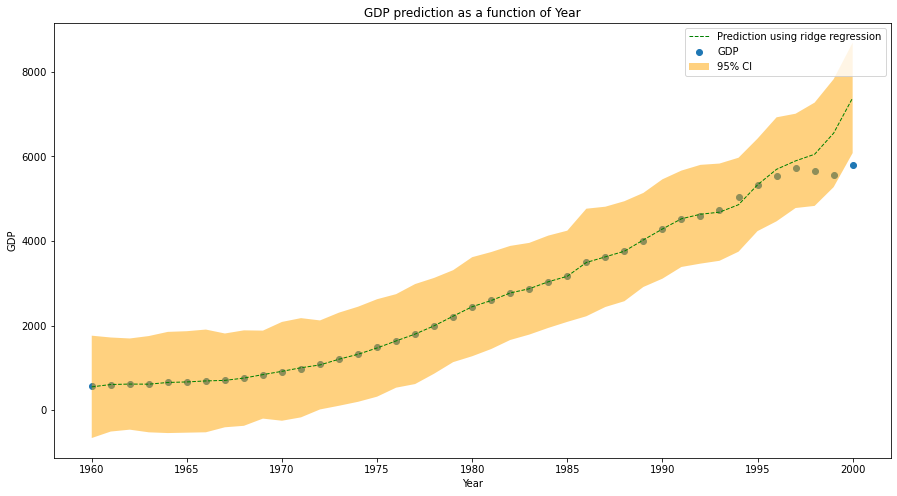

In [46]:
X_for_var_ls_ss, w_for_var_ls_ss = (X_ls_ss[:, 1:], LS_w_ss[1:]) if d_ss > 0 else (X_ls_ss, LS_w_ss)
var_ = variance_least_squares_line(X_for_var_ls_ss, y, LS_ss_prediction_data)
lower_CI_line_ls_ss, upper_CI_line_ls_ss = confidence_interval(X_for_var_ls_ss.shape[0], X_for_var_ls_ss.shape[1], LS_ss_prediction_data, var_)
plt.figure(figsize=(15,8))
plt.scatter(X[:, 0], y, label="GDP")
plt.plot(X[:, 0], LS_ss_prediction_data, color="g", lw=1, ls='--', label="Prediction using ridge regression")
plt.gca().fill_between(X[:, 0], np.squeeze(lower_CI_line_ls_ss), np.squeeze(upper_CI_line_ls_ss),
                       label="95% CI",
                       #color="#b9cfe7",
                       color="orange",
                       alpha=0.5,
                       edgecolor=None)
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("GDP prediction as a function of Year")
plt.legend()
plt.show()

In [47]:
lambda_r_ss, d_r_ss = cross_val_ridge(X_train_ss, y_train, max_lambda=2, plot=False)
print("The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively:",
      lambda_r_ss, d_r_ss)

The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively: 1.74 3


In [48]:
X_r_ss = build_poly(X_ss, d_ss)
X_train_r_ss, X_test_r_ss, _, _ = train_test_split(X_r_ss, y)

In [49]:
Ridge_w_lambda_ss = ridge_regression(X_train_r_ss, y_train, lambda_r_ss)

Ridge_prediction_lambda_ss_data = predict(X_r_ss, Ridge_w_lambda_ss)
Ridge_prediction_lambda_ss_test = predict(X_test_r_ss, Ridge_w_lambda_ss)

In [50]:
print("Testing R^2: ", R_squared(y_test, Ridge_prediction_lambda_ss_test),
      "\nFull data R^2:", R_squared(y, Ridge_prediction_lambda_ss_data))

Testing R^2:  -5.470780988984011 
Full data R^2: 0.9237948247762786


In [51]:
print("Full data adjusted R^2:", adjusted_R_squared(y, Ridge_prediction_lambda_ss_data, X.shape[1]))

Full data adjusted R^2: 0.8614451359568702


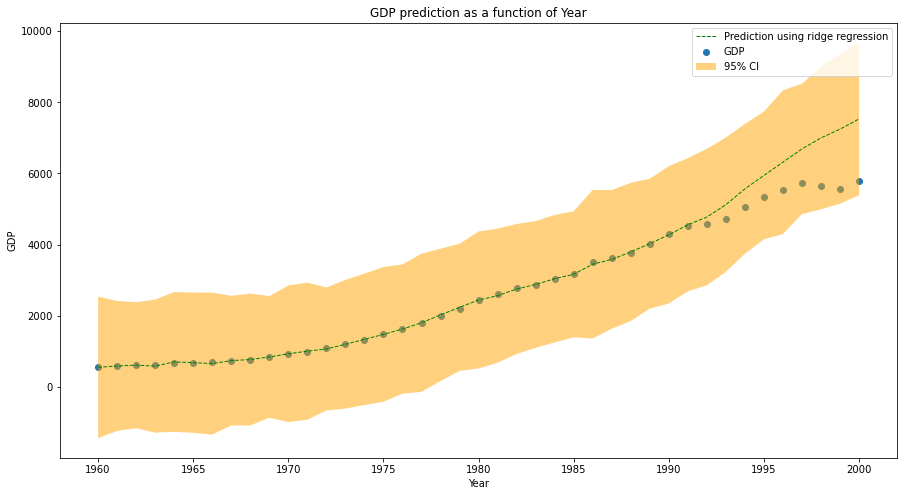

In [52]:
X_for_var_r_ss, w_for_var_r_ss = (X_r_ss[:, 1:], Ridge_w_lambda_ss[1:]) if d_r_ss > 0 else (X_r_ss, Ridge_w_lambda_ss)
var_ = variance_least_squares_line(X_for_var_r_ss, y, Ridge_prediction_lambda_ss_data)
lower_CI_line_r_ss, upper_CI_line_r_ss = confidence_interval(X_for_var_r_ss.shape[0], X_for_var_r_ss.shape[1], Ridge_prediction_lambda_ss_data, var_)
plt.figure(figsize=(15,8))
plt.scatter(X[:, 0], y, label="GDP")
plt.plot(X[:, 0], Ridge_prediction_lambda_ss_data, color="g", lw=1, ls='--', label="Prediction using ridge regression")
plt.gca().fill_between(X[:, 0], np.squeeze(lower_CI_line_r_ss), np.squeeze(upper_CI_line_r_ss),
                       label="95% CI",
                       #color="#b9cfe7",
                       color="orange",
                       alpha=0.5,
                       edgecolor=None)
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("GDP prediction as a function of Year")
plt.legend()
plt.show()

### General to simple

In [53]:
idx = general_to_simple(X_train, y_train)

In [54]:
X_g2s = X[:, idx]
X_train_g2s, X_test_g2s, _, _ = train_test_split(X_ss, y)

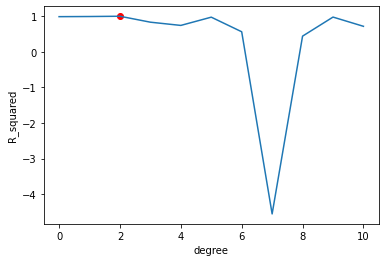

In [55]:
d_g2s = degree_cross_val(X_train_g2s, y_train, 10)
X_ls_g2s = build_poly(X_g2s, d_g2s)
X_train_ls_g2s, X_test_ls_g2s, _, _ = train_test_split(X_ls_g2s, y)

In [56]:
LS_w_g2s = least_squares(X_train_ls_g2s, y_train)

LS_g2s_prediction_data = predict(X_ls_g2s, LS_w_g2s)
LS_g2s_prediction_test = predict(X_test_ls_g2s, LS_w_g2s)

In [57]:
print("Testing R^2:  ", R_squared(y_test, LS_g2s_prediction_test),
      "\nFull data R^2:", R_squared(y, LS_g2s_prediction_data))

Testing R^2:   0.5619966998140058 
Full data R^2: 0.994733797474532


In [58]:
print("Full data adjusted R^2:", adjusted_R_squared(y, LS_g2s_prediction_data, X.shape[1]))

Full data adjusted R^2: 0.9904250863173311


In [59]:
lambda_r_g2s, d_r_g2s = cross_val_ridge(X_train_g2s, y_train, plot=False)
print("The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively:",
      lambda_r_g2s, d_r_g2s)

The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively: 0.91 3


In [60]:
X_r_g2s = build_poly(X_g2s, d_g2s)
X_train_r_g2s, X_test_r_g2s, _, _ = train_test_split(X_r_g2s, y)

In [61]:
Ridge_w_lambda_g2s = ridge_regression(X_train_r_g2s, y_train, lambda_r_g2s)

Ridge_prediction_lambda_g2s_data = predict(X_r_g2s, Ridge_w_lambda_g2s)
Ridge_prediction_lambda_g2s_test = predict(X_test_r_g2s, Ridge_w_lambda_g2s)

In [62]:
print("Testing R^2: ", R_squared(y_test, Ridge_prediction_lambda_g2s_test),
      "\nFull data R^2:", R_squared(y, Ridge_prediction_lambda_g2s_data))

Testing R^2:  -8.896389225635042 
Full data R^2: 0.8834411759812061


In [63]:
print("Full data adjusted R^2:", adjusted_R_squared(y, Ridge_prediction_lambda_g2s_data, X.shape[1]))

Full data adjusted R^2: 0.7880748654203746
